# HamletMTA Final Report

- [David Hadaller](#David-Hadaller)
- [Angelika Shastapalava](#Angelika-Shastapalava)
- [Sam Mundle](#Sam-Mundle)
- [Excel Espina](#Excel-Espina)

## Project Aims

We will use MTA bus data, Monte Carlo passenger simulation and weather data to create a model that will determine how long a passenger should wait for the next bus, before giving up and chosing an alternative mode of transportation. Our focus thus far has been on one particular bus stop (the southbound M100 on 135th street) in August of 2017. However, this model could be iterated system-wide for every bus stop location. 

The diagram below serves as a reference for our analysis and is explained in more detail in the passages that follow.

![diagram](analysis_diagram.png)

### Monte Carlo Simulation

In our Monte Carlo simulation, we will first assume that there is a uniform probability that a passenger will approach a stop at any given time of day. The reason for this choice is for it's realism (it is a common assumtion among staff analysts at the MTA's operations and planning department) and for it's ease of computation. Later on, we can experiment different ridership behaviors such as a bimodal probability distribution (peak in the early morning and evening for commuters). 

#### Passenger Wait Times ([Sam](#Sam-Mundle))

We view each day's bus arrivals, at a given bus stop, as points on a timeline. Similarly, each  passenger arival at the bus stop falls also on the day's timeline. Calculating wait times then amounts to finding the difference between the passenger's arrival and the arrival of the very next bus along this timeline. Our goal here is to create a dataset with the time (as in time of day) of a passenger's approach to the bus station as the independent variable and the wait time as the dependent variable. This data will serve as the validation set for our model.

#### Bus Time Deltas/headways ([David](#David-Hadaller))

For the simulated passengers, each approaching the bus stop at some random time, we would like to find how crowded the bus they board will be. To find this, we will simulate many passengers "boarding" busses by assigning a population of $n$ daily passengers a uniform random timestamp between the last and first busses of the day. Buses which feature an abnormally long timedelta (long time interval between current and last bus arrival) will generally be more crowded, since more passengers accumulate at the bus stop as time goes on. Again, the time of day is our independent variable and the number of people on the bus (crowding) is the dependent variable.  This data will serve as the validation set for our model.

### Weather Data ([Angelika](#Angelika-Shastapalava))

Weather data will include columns for precipitation, wind speed, and visibility for the month of August 2017 in NYC. These will serve as our features for predicting crowding and wait time.


### Machine Learning Model ([Excel](#Excel-Espina))

The feature variables will be include weather data columns and time of day, while the target variables will be the crowding and wait times as experienced by the passengers (to predict what we simulated in the Monte Carlo method step.) Our goal is to produce a general weather-conscious model that predicts passenger experience (wait time and crowdedness)

Considerations for this step include, but are not limited to:

- model evaluation (accuracrecall,prediction, lift and all that)
- model type (linear, non linear/ regression/decision tree)


## Data Sources

[MTA Schedules](http://web.mta.info/nyct/service/bus/bklnsch.htm#top) (need to figure out best way to scrape or source better structured data)

[MTA Bus Statistics](https://www.kaggle.com/stoney71/new-york-city-transport-statistics)

[Weather.Gov](https://www.weather.gov/okx/CentralParkHistorical) Data from a weather monitor in central park; Each day, a 1:30 am report holds 24 hours of weather data starting at 12:00 am EST the previous day and the reports look like [this](https://forecast.weather.gov/product.php?site=NWS&issuedby=NYC&product=CLI&format=CI&version=1&glossary=1&highlight=off).

# David Hadaller

In [7]:
import pandas as pd
from pandas import Timestamp

import matplotlib.dates
import matplotlib.pyplot as plt

import numpy as np
import datetime
import math
import sys

In [8]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [9]:
#this is a dataset for the timestamps of busses at the Amsterdam & 125th st stop on M100 line going uptown 
busDepartures = pd.read_csv("../data/Arrivals_M100.csv",index_col=0)

# loopTime is the minimum amount of time, in minutes, that it takes a bus to complete the bus route and 
    # arrive at this stop to complete the circuit once again
loopTime = datetime.timedelta(minutes=105)

# Ensure ordering by VehicleRef (a vehicle identifier for busses) and RecordedAtTime (timestamps)
busDepartures = busDepartures.sort_values(['VehicleRef','RecordedAtTime'])

# Resetting Index and deleting resulting index column after ordering for shift later on.
busDepartures = busDepartures.reset_index()
busDepartures.drop(columns=['index',],inplace=True)

# Ensure that RecordedAtTime is of correct data type to find timedelta
busDepartures['RecordedAtTime'] = pd.to_datetime(busDepartures['RecordedAtTime'])

# find difference between CURRENT timestamp and PREVIOUS for each gps-timestamp
    #busDepartures['timeDelta'] = busDepartures_Grouped['RecordedAtTime'].diff()
busDepartures['timeDelta'] = busDepartures['RecordedAtTime'].diff()

# we want to find all the timestamps where busses pull away from this one stop. 
    # the departure time is when we consider that a passenger is no longer waiting for their journey to start. 
    # hence, we count bus idleing as part of the passengers experienced wait time

# wherever the difference between two consecutive timestamps is greater than the loopTime, 
    # the bus has finished it's route and come back to the same stop it started at.
    # The bus is not idleing.  
busDepartures['hasLooped'] = busDepartures['timeDelta'] > loopTime

#fixing some edge cases e.g. the first datapoint has no timedeta because no other time precedes it
busDepartures.loc[0,'timeDelta'] = 0

# # where the timedeta is NaT, set to haslooped=True. We do this so that the first Entry for a given Vehicleref won't 
#     # count as a departure time, but the last entry from the previous VehicleRef entry will.
# busDepartures.loc[busDepartures['timeDelta'].isnull(),'hasLooped'] = True

# wherever the next arrival is a Looparound, the current timestamp is considered a departure from the stop
busDepartures['isDeparting'] = busDepartures['hasLooped'].shift(-1)

#the last entry in the entire dataframe must be included as a departure
busDepartures.loc[busDepartures.index[-1], 'isDeparting']= True

# If the next bus is not the same as the current bus, then this entry must be considered a departure
busDepartures['NextVehicleRef'] = busDepartures['VehicleRef'].shift(-1).fillna("") #create next bus column by shifting current bus up by 1 relative to index
mask = busDepartures['VehicleRef'] != busDepartures['NextVehicleRef']
busDepartures.loc[mask, 'isDeparting'] = True

# return all rows where the busses are departing
busDepartures = busDepartures[busDepartures['isDeparting'] != False]

Now we need to recalculate the `timeDelta`s (the time since the last bus departed from the stop). Before we wanted values like 12 hours, because busses before a time delta like that are certainly departing, not idleing (they're the last bus for 12 hours). This time, we ordering by date. TO do that we must separate the date from the timestamps in the  `RecordedAtTime` column.

In [10]:
#busDepartures = busDepartures.loc[:,['RecordedAtTime','VehicleRef']]

# need to change the datetime to string to apply string split methods
busDepartures['RecordedAtTime'] = busDepartures['RecordedAtTime'].dt.strftime('%Y-%m-%d %H:%M:%S')

#apply split to retrieve date without time
splitCol = busDepartures['RecordedAtTime'].str.split(' ', 1, expand=True).rename(columns={0:'Date', 1:'Time'}) 
busDepartures['Date'] = splitCol['Date'] 

#apply split to retrieve time without date 
busDepartures['Time'] = splitCol['Time']
busDepartures['Time'] = pd.to_datetime(busDepartures['Time'],format='%H:%M:%S')

busDepartures = busDepartures.sort_values(['RecordedAtTime'])

#at the start of each new day, set the time delta to 0. (we assume no passenger is waiting through night for next bus)
busDepartures['TimeDelta'] = busDepartures['Time'].diff()
busDepartures['PrevDate'] = busDepartures['Date'].shift(1)
mask = busDepartures['PrevDate'] != busDepartures['Date']
busDepartures.loc[mask,'TimeDelta'] = pd.Timedelta(0, unit='m')

# drop columns no longer needed
busDepartures.drop(['Time','PrevDate'],axis=1,inplace=True)

In [11]:
# busDepartures.columns
# busDepartures.shape
# busDepartures.dtypes

Before we begin the simulation, we need to establish what will become the arguments to `numpy.random.uniform(low=0.0, high=1.0, size=None)`. Below, we find the `low` and `high` parameters. That is, we find the first and last bus arrival times for each day.

In [12]:
DailyBusMinMax= busDepartures.loc[:,['RecordedAtTime','Date']]

DailyBusMinMax = DailyBusMinMax.drop_duplicates()

DailyBusMax = DailyBusMinMax.groupby('Date').max()
DailyBusMin = DailyBusMinMax.groupby('Date').min()

DailyBusMinMax = pd.merge(left=DailyBusMin, right=DailyBusMax, how='inner',on='Date', suffixes=('Min', 'Max'))
DailyBusMinMax = DailyBusMinMax.rename(columns={'RecordedAtTimeMin':'EarliestBusDeparture', 'RecordedAtTimeMax':'LatestBusDeparture'})

DailyBusMinMax.reset_index(level=0, inplace=True)
DailyBusMinMax['Date'] = pd.to_datetime(DailyBusMinMax['Date'],format='%Y-%m-%d')
DailyBusMinMax['EarliestBusDeparture'] = pd.to_datetime(DailyBusMinMax['EarliestBusDeparture'], format='%Y-%m-%d %H:%M:%S')
DailyBusMinMax['LatestBusDeparture'] = pd.to_datetime(DailyBusMinMax['LatestBusDeparture'], format='%Y-%m-%d %H:%M:%S')

DailyBusMinMax.head(30)

,Date,EarliestBusDeparture,LatestBusDeparture
0,2017-08-01,2017-08-01 00:11:39,2017-08-01 23:13:22
1,2017-08-02,2017-08-02 00:22:34,2017-08-02 22:55:06
2,2017-08-03,2017-08-03 00:35:38,2017-08-03 23:27:49
3,2017-08-04,2017-08-04 00:37:30,2017-08-04 23:39:27
4,2017-08-05,2017-08-05 00:39:12,2017-08-05 23:31:11
5,2017-08-06,2017-08-06 00:41:24,2017-08-06 23:52:56
6,2017-08-07,2017-08-07 00:32:30,2017-08-07 23:04:06
7,2017-08-08,2017-08-08 00:04:29,2017-08-08 23:56:22
8,2017-08-09,2017-08-09 00:05:59,2017-08-09 23:47:54
9,2017-08-10,2017-08-10 00:28:04,2017-08-10 23:19:19


In the cell below, we take the bus departure times (when the bus pulls out of the stop), the dates associated with each bus departure time (to help with subsequent merges) and the timedeltas (which we may plot later on) from the `busDepartures`, which we got from the original `Arrivals_M100` data

In [13]:
busDepartureTimes = busDepartures.loc[:,['RecordedAtTime','VehicleRef','TimeDelta','Date']]
busDepartureTimes = busDepartureTimes.rename(columns={'RecordedAtTime':'BusDepartureTime'})

# Change Column DataTypes from String (object) to DateTime
busDepartureTimes['BusDepartureTime'] = pd.to_datetime(busDepartureTimes['BusDepartureTime'], format='%Y-%m-%d %H:%M:%S')
busDepartureTimes['Date'] = pd.to_datetime(busDepartureTimes['Date'], format='%Y-%m-%d %H:%M:%S')
busDepartureTimes = busDepartureTimes.drop_duplicates()

busDepartureTimes.head()

,BusDepartureTime,VehicleRef,TimeDelta,Date
1089,2017-08-01 00:11:39,NYCT_4349,00:00:00,2017-08-01
1906,2017-08-01 00:21:06,NYCT_4368,00:09:27,2017-08-01
4323,2017-08-01 01:01:11,NYCT_8375,00:40:05,2017-08-01
1045,2017-08-01 06:11:35,NYCT_4348,05:10:24,2017-08-01
1755,2017-08-01 06:41:31,NYCT_4363,00:29:56,2017-08-01


Next, we define a simulation function which gets the `low` and `high` bounds of the uniform distribution from the DailyBusMinMax dataframe and then takes `NumPassengers` for population size of passengers to simulate. 

This simulation function creates a "pivot table" with the Date as pseudo-index and an artificial passengerId for column headers. For each date, the table contains each passenger in NumPassengers simulated bus arrival time (the time at which each passenger approaches the bus stop with the hopes of boarding a bus.)

Of course, the table that results isn't a true pivot table, because the Date column is just another column, rather than a pandas index. Keeping the Date as a column allows us to reference it as a column later on, which will come in handy when we need to return a series of dates.

In [14]:
def passengerSim(DailyBusMinMax, NumPassengers):
    
    #time between the first and last bus arrivals
    dailyDelta = DailyBusMinMax['LatestBusDeparture'] - DailyBusMinMax['EarliestBusDeparture']
    
    # the first bus arrival
    dailyMin = DailyBusMinMax['EarliestBusDeparture']
    
    #number of dates to simulate for
    NumDates = len(DailyBusMinMax.Date)
    
    #this vectorized calculation follows the formula dailyDelta * randomVar + firstBusArrival to choose a random time
        # between the EarliestBusDeparture and the LatestBusDeparture.
        # this is done for every date and for each passenger in NumPassengers
    pSim = pd.DataFrame(np.random.uniform(0,1,(NumDates,NumPassengers)))
    pSim = pSim.mul(dailyDelta,axis=0)
    pSim = pSim.add(dailyMin,axis=0)
    
    # add a dates column to front of dataframe  
    pSim.insert(loc=0, column='Date', value=DailyBusMinMax['Date'])
    
    return pSim

In [15]:
sim = passengerSim(DailyBusMinMax,500)
sim.head()

,Date,0,1,2,3,4,5,6,7,8,...,490,491,492,493,494,495,496,497,498,499
0,2017-08-01,2017-08-01 02:46:17.163443229,2017-08-01 01:55:34.601552247,2017-08-01 11:54:30.291083276,2017-08-01 10:49:48.845147670,2017-08-01 17:25:36.637853586,2017-08-01 23:06:03.454300862,2017-08-01 18:12:22.160756400,2017-08-01 13:49:19.904695768,2017-08-01 18:32:20.104780402,...,2017-08-01 07:51:52.590882216,2017-08-01 13:09:40.734232592,2017-08-01 15:41:57.296820661,2017-08-01 12:08:23.884153097,2017-08-01 05:38:10.391489329,2017-08-01 17:54:41.808822757,2017-08-01 20:58:56.133045671,2017-08-01 20:06:59.054547058,2017-08-01 01:23:04.796905922,2017-08-01 08:32:04.794719960
1,2017-08-02,2017-08-02 04:43:32.139214505,2017-08-02 07:37:52.841432712,2017-08-02 11:00:32.741800750,2017-08-02 06:43:21.992000785,2017-08-02 22:15:58.922831584,2017-08-02 05:08:34.834084085,2017-08-02 17:12:05.201065789,2017-08-02 13:37:48.468671487,2017-08-02 06:31:18.962712684,...,2017-08-02 16:04:34.539809169,2017-08-02 09:29:15.417745406,2017-08-02 02:26:42.228915064,2017-08-02 18:02:32.187491168,2017-08-02 18:41:14.463973814,2017-08-02 03:12:43.449503970,2017-08-02 22:51:37.591959194,2017-08-02 05:22:08.718578434,2017-08-02 22:42:09.288394461,2017-08-02 20:05:15.743310889
2,2017-08-03,2017-08-03 16:48:14.964687550,2017-08-03 15:49:38.395178867,2017-08-03 15:00:46.562982734,2017-08-03 07:57:58.437005518,2017-08-03 16:53:01.141542620,2017-08-03 03:13:19.625549216,2017-08-03 16:19:01.322725587,2017-08-03 19:21:45.242142616,2017-08-03 18:36:55.292538456,...,2017-08-03 04:45:31.142817102,2017-08-03 15:56:19.846499066,2017-08-03 19:49:18.583223840,2017-08-03 18:57:54.788594636,2017-08-03 02:25:04.807218515,2017-08-03 10:01:57.973112336,2017-08-03 05:13:51.185440328,2017-08-03 21:41:02.919945073,2017-08-03 20:26:50.993481335,2017-08-03 11:01:14.662811828
3,2017-08-04,2017-08-04 01:09:26.889684239,2017-08-04 08:06:34.285919302,2017-08-04 15:18:38.468247914,2017-08-04 07:18:57.567263674,2017-08-04 09:05:06.763190601,2017-08-04 05:13:33.701097074,2017-08-04 18:33:09.556430372,2017-08-04 05:48:01.436321539,2017-08-04 19:38:42.126547550,...,2017-08-04 19:43:57.217468226,2017-08-04 21:01:11.334352720,2017-08-04 12:18:17.749128331,2017-08-04 22:42:30.218274055,2017-08-04 04:58:39.900894928,2017-08-04 17:26:34.556573423,2017-08-04 09:51:51.779417172,2017-08-04 12:49:36.087349667,2017-08-04 16:47:54.124600264,2017-08-04 22:46:04.026296463
4,2017-08-05,2017-08-05 12:59:55.339482652,2017-08-05 21:36:50.090197724,2017-08-05 13:49:31.055112891,2017-08-05 18:59:35.314211470,2017-08-05 04:51:34.244019743,2017-08-05 19:49:58.725037220,2017-08-05 20:36:26.122721495,2017-08-05 07:43:59.167141583,2017-08-05 17:56:33.125966568,...,2017-08-05 21:03:52.835230855,2017-08-05 10:34:07.215583906,2017-08-05 22:17:58.408659813,2017-08-05 14:39:10.247046657,2017-08-05 02:00:11.639107967,2017-08-05 13:30:38.001106267,2017-08-05 21:58:16.867075193,2017-08-05 14:47:36.857537537,2017-08-05 08:04:01.058839605,2017-08-05 21:15:11.767596556


Here, we reorganize the results of the passenger simulation to get a table that has one single `passengerId` column, instead of one column for each passenger. This is will allow us to perform a merge in the following step.

In [16]:
sim = sim.melt(id_vars='Date')
sim = sim.rename(columns={'variable':'passengerId','value':'passengerArrivalTime'})
sim.head()

,Date,passengerId,passengerArrivalTime
0,2017-08-01,0,2017-08-01 02:46:17.163443229
1,2017-08-02,0,2017-08-02 04:43:32.139214505
2,2017-08-03,0,2017-08-03 16:48:14.964687550
3,2017-08-04,0,2017-08-04 01:09:26.889684239
4,2017-08-05,0,2017-08-05 12:59:55.339482652


As promised, we now merge the passenger simulation,`sim` with the bus departure times, `busDepartureTimes`. The result of the code below is a lookup table where each passenger arrival time is associated with one bus arrival time; that is to say, the passengers are associated with the bus they board (which will always be the next bus that departs from the stop after they arrive.)

In [17]:
# The powerset of all passenger-bus combinations
busBoarding = pd.merge(right=sim, left=busDepartureTimes, on='Date', how='inner')

#  busses already departed from stop cannot be boarded by passengers who arrive at the stop later on.
    # (no going back in time)
busBoarding = busBoarding.loc[busBoarding['BusDepartureTime']>=busBoarding['passengerArrivalTime']]

# the passenger is reasonable and will board the first bus that departs from the stop after they arrive
busBoarding = busBoarding.groupby(['Date','passengerId','passengerArrivalTime']).first()

# we reset the index to group by a different column in the next step
busBoarding = busBoarding.reset_index().sort_values(['Date','BusDepartureTime','passengerId'])
busBoarding.head()


,Date,passengerId,passengerArrivalTime,BusDepartureTime,VehicleRef,TimeDelta
329,2017-08-01,329,2017-08-01 00:16:36.688331063,2017-08-01 00:21:06,NYCT_4368,00:09:27
336,2017-08-01,336,2017-08-01 00:20:21.739795318,2017-08-01 00:21:06,NYCT_4368,00:09:27
373,2017-08-01,373,2017-08-01 00:18:49.927982582,2017-08-01 00:21:06,NYCT_4368,00:09:27
17,2017-08-01,17,2017-08-01 00:52:52.702503782,2017-08-01 01:01:11,NYCT_8375,00:40:05
18,2017-08-01,18,2017-08-01 00:53:41.735033812,2017-08-01 01:01:11,NYCT_8375,00:40:05


Now, we calcuate the number of people per bus by grouping by `BusArrivalTime` and then counting the number of entries in each group. We then merge this `busCrowding` DataFrame back into our `busBoarding` DataFrame from the previous step to give us a `numPassengersPerBus` column, which tells us exactly how many of our simulated passengers boarded each bus.

In [18]:
busCrowding = busBoarding.groupby(['BusDepartureTime']).count()
busCrowding = pd.DataFrame(busCrowding['passengerId']).rename(columns={'passengerId':'numPassengersPerBus'})
busCrowding = busCrowding.reset_index()

busBoarding = pd.merge(left=busBoarding, right=busCrowding, on='BusDepartureTime', how='inner')
busBoarding.head()
busBoarding.shape

(14500, 7)

We now take a few columns of the `busBoarding`data that to plot the relationship between `passengerArrivalTime` and `numPassengersPerBus`.

In [19]:
plotData = busBoarding.loc[:,['passengerArrivalTime','numPassengersPerBus']]
plotData['passengerArrivalTime'] = plotData.passengerArrivalTime.dt.time
plotData.head()
plotData.shape

(14500, 2)

Finally, we have our plot.

(array([-10000.,      0.,  10000.,  20000.,  30000.,  40000.,  50000.,
         60000.,  70000.,  80000.,  90000.]),
 <a list of 11 Text xticklabel objects>)

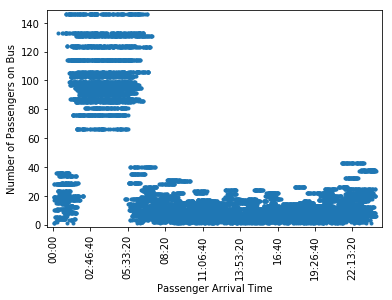

In [20]:
plotData = plotData.sort_values('passengerArrivalTime', ascending=True)
_= plt.plot(plotData['passengerArrivalTime'], plotData['numPassengersPerBus'],'.',linestyle='none')
_ = plt.xlabel('Passenger Arrival Time')
_ = plt.ylabel('Number of Passengers on Bus')
_ = plt.margins(0.02) # Keeps data off plot edges
plt.xticks(rotation='vertical')

Notice that the above plot features a series of points a the 140 people mark. This could signify that the uniform distribution hypothesis may have been too generous, since, during the hours between 3am and 5am, most people are asleep. And few busses run druring those times, so assuming people will wait for hours until the next bus comes might be an unnatural assumption to make. FOr this reason, we can restrict our analysis to the times between 5am and 1am the next day for our machine learning models.

In [21]:
busBoarding.to_csv('../data/busBoarding.csv')

In [23]:
busBoarding.BusDepartureTime.head()

0   2017-08-01 00:21:06
1   2017-08-01 00:21:06
2   2017-08-01 00:21:06
3   2017-08-01 01:01:11
4   2017-08-01 01:01:11
Name: BusDepartureTime, dtype: datetime64[ns]

# Sam Mundle

In [ ]:
# Find the elapsed time between passenger arrival and bus arrival (Wait time)
busBoarding['WaitTime'] = busBoarding['BusArrivalTime'] - busBoarding['passengerArrivalTime']
busBoarding.shape

In [ ]:
waitPlotData = busBoarding[['passengerArrivalTime', 'WaitTime']].copy()
waitPlotData['passengerArrivalTime'] = waitPlotData.passengerArrivalTime.dt.time
waitPlotData.dtypes

In [ ]:
waitPlotData = waitPlotData.sort_values('passengerArrivalTime', ascending=True)[0:500]
_= plt.plot(waitPlotData['passengerArrivalTime'], waitPlotData['WaitTime'],'.',linestyle='none')
_ = plt.xlabel('Passenger Arrival Time')
_ = plt.ylabel('Wait Time For Bus')
_ = plt.margins(0.02) # Keeps data off plot edges
plt.xticks(rotation='vertical')



First we import relevant libraries and generate a dataframe representing all of the arrivals at a single stop in a single month traveling in one of two directions on the M100 bus route. 

It should be noted that there are relatively few entries for the month (107) due to data loss earlier in the cleaning process. Further work on cleaning is necessary

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

mta_df = pd.read_csv('../data/M100_Aug_W125_st.csv', error_bad_lines=False)
mta_df.shape

(89, 19)

Then the dataframe is sorted based on 'RecordedAtTime' which, since all entries are while the bus has reached the stop, represent the actual arrival times. 

In [4]:
mta_df['RecordedAtTime'] = pd.to_datetime(mta_df['RecordedAtTime'])
mta_df.sort_values("RecordedAtTime", inplace=True)
mta_df.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation.Latitude,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime,time_diff_bus,time_diff_bus_mins
0,2017-08-01 07:51:49,0,M100,1 AV/125 ST,40.801968,-73.931358,INWOOD 220 ST via AMSTERDAM via BWAY,40.871902,-73.913101,NYCT_8368,40.810861,-73.952819,W 125 ST/ST NICHOLAS AV,at stop,21.0,2017-08-01 07:52:03,07:49:06,NaN,0
1,2017-08-01 07:51:49,0,M100,1 AV/125 ST,40.801968,-73.931358,INWOOD 220 ST via AMSTERDAM via BWAY,40.871902,-73.913101,NYCT_8368,40.810861,-73.952819,W 125 ST/ST NICHOLAS AV,at stop,21.0,2017-08-01 07:52:03,07:50:48,0 days 00:00:00.000000000,0
2,2017-08-01 07:51:49,0,M100,1 AV/125 ST,40.801968,-73.931358,INWOOD 220 ST via AMSTERDAM via BWAY,40.871902,-73.913101,NYCT_8368,40.810861,-73.952819,W 125 ST/ST NICHOLAS AV,at stop,21.0,2017-08-01 07:52:03,07:51:39,0 days 00:00:00.000000000,0
3,2017-08-01 11:02:25,0,M100,1 AV/125 ST,40.801968,-73.931358,INWOOD 220 ST via AMSTERDAM via BWAY,40.871902,-73.913101,NYCT_8384,40.810907,-73.952928,W 125 ST/ST NICHOLAS AV,at stop,11.0,2017-08-01 11:02:42,11:04:39,0 days 03:10:39.000000000,191
4,2017-08-01 13:42:23,0,M100,1 AV/125 ST,40.801968,-73.931358,INWOOD 220 ST via AMSTERDAM via BWAY,40.871902,-73.913101,NYCT_8391,40.810881,-73.952865,W 125 ST/ST NICHOLAS AV,at stop,17.0,2017-08-01 13:43:07,13:35:20,0 days 02:40:25.000000000,161


The arrivals dataframe is initialized with a controlled number of passenger arrival time entries and can have the frequency of random times changed in its definition statement

In [5]:
def select_random_dates(frequency, NumDataPoints):
    date_range = pd.date_range(start='2017-08-01', end='2017-08-30', freq=frequency)
    random_dates = pd.to_datetime(
        np.concatenate([
                np.random.choice(date_range[1:-1], size=NumDataPoints, replace=False)
            ])
        )
    return random_dates

arrivals_df = pd.DataFrame()
arrivals_df['PassengerTime'] = select_random_dates('1min', 600)
arrivals_df.head(10)

,PassengerTime
0,2017-08-13 04:33:00
1,2017-08-09 16:57:00
2,2017-08-27 05:31:00
3,2017-08-14 20:36:00
4,2017-08-22 06:51:00
5,2017-08-18 18:14:00
6,2017-08-04 21:41:00
7,2017-08-13 16:20:00
8,2017-08-25 04:18:00
9,2017-08-28 23:53:00


The next arriving bus is found for each of the random passenger arrival times defined above as well as the time delta between the two, representing wait time.

In [6]:
def findNextBus(arrivals_df, mta_df):
    for arrivalIndex, arrivalRow in arrivals_df.iterrows():
        for mtaIndex, mtaRow in mta_df.iterrows():
            if (mtaRow['RecordedAtTime'] > arrivalRow[0]):
                arrivals_df.loc[arrivalIndex,'NextBus'] = mtaRow['RecordedAtTime']
                break

findNextBus(arrivals_df, mta_df)
arrivals_df['WaitTime'] = arrivals_df['NextBus'] - arrivals_df['PassengerTime']
arrivals_df.head(10)

,PassengerTime,NextBus,WaitTime
0,2017-08-13 04:33:00,2017-08-13 17:24:54,12:51:54
1,2017-08-09 16:57:00,2017-08-10 06:18:56,13:21:56
2,2017-08-27 05:31:00,2017-08-27 07:18:07,01:47:07
3,2017-08-14 20:36:00,2017-08-15 13:27:34,16:51:34
4,2017-08-22 06:51:00,2017-08-22 09:49:46,02:58:46
5,2017-08-18 18:14:00,2017-08-18 20:33:35,02:19:35
6,2017-08-04 21:41:00,2017-08-04 21:48:55,00:07:55
7,2017-08-13 16:20:00,2017-08-13 17:24:54,01:04:54
8,2017-08-25 04:18:00,2017-08-25 07:35:09,03:17:09
9,2017-08-28 23:53:00,2017-08-29 15:42:01,15:49:01


# Angelika Shastapalava

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import numpy as np


reading the file

In [ ]:
df = pd.read_csv("../data/1401011_weather_data.csv", delimiter = ',', usecols = (5,24), index_col='DATE')

In [ ]:
df.head()

In [ ]:
df.dtypes


selecting time period of aug 2017

In [ ]:
weather = df.loc['2017-08-01' : '2017-09-01']

In [ ]:
weather.info()

our data contains some na values. in addition some precip values contain 
letter 'T' or 's'.
droping na and precip values that contain T or s letter in them

In [ ]:
weather = weather.dropna()
weather = weather[~weather.HOURLYPrecip.str.contains("T")]
weather = weather[~weather.HOURLYPrecip.str.contains("s")]

In [ ]:
weather.info()

In [ ]:
weather.HOURLYPrecip=pd.to_numeric(weather.HOURLYPrecip)
weather.reset_index()

In [ ]:
%matplotlib inline
import seaborn; seaborn.set()
weather.plot(y='HOURLYPrecip', use_index=True)
plt.xlabel('August 2017')
plt.ylabel('Hourly Precipitation in Inches')

creating another df for visibility

In [ ]:
vis = pd.read_csv("../data/1401011_weather_data.csv", delimiter = ',', usecols = (5,8),index_col='DATE')

In [ ]:
vis.head()

In [ ]:
vis.dtypes

selecting time period of aug 2017

In [ ]:
visib = vis.loc['2017-08-01' : '2017-09-01']

In [ ]:
visib.info()

droping na values and data that contain string 'V' in it

In [ ]:
visib = visib.dropna()
visib = visib[~visib.HOURLYVISIBILITY.str.contains("V")]

In [ ]:
visib.info()

converting visibility column to numeric in order to create a plot

In [ ]:
visib.HOURLYVISIBILITY=pd.to_numeric(visib.HOURLYVISIBILITY)

In [ ]:
visib.plot(y='HOURLYVISIBILITY', use_index=True)
plt.xlabel('August 2017')
plt.ylabel('Hourly Visibility in miles')

Let's see what dates hourly visibility was below 1 mile

In [ ]:
visib.loc[visib.HOURLYVISIBILITY < 1]

Let's see what dates horly precipitation was above 0.5 inches

In [ ]:
weather.loc[weather.HOURLYPrecip >= 0.5]

It seems like on august 18th precipitation was relatively high and visibility was low
This is important because it can influence waiting time and crowdiness in busses.
For better understanding lets visualize it with seaborn plots

In [ ]:
weather.plot(y='HOURLYPrecip', use_index=True)
plt.xlabel('August 2017')
plt.ylabel('Hourly Precipitation in Inches')

visib.plot(y='HOURLYVISIBILITY', use_index=True)
plt.xlabel('August 2017')
plt.ylabel('Hourly Visibility in miles')

Indeed, we have low hourly visibility and high precipitation 
around the same time (aug 18th).
We can expect this date to have longer waiting time and 
higher crowdiness in busses in our future model

Let's see if there any other dates that can influence our 
dependable variables

In [ ]:
print(visib.loc[visib.HOURLYVISIBILITY < 2])
print(weather.loc[weather.HOURLYPrecip >= 0.2])

It seems like on aug 15th and 22nd there is 
a hight chance of finding disruption of bus services as well

Now, let's find out if there were any dates with hight wind speed

In [ ]:
w = pd.read_csv("../data/1401011_weather_data.csv", delimiter = ',', usecols = (5,17), index_col='DATE')

In [ ]:
w.head()

In [ ]:
w.dtypes

In [ ]:
print(w.shape)
print(len(w))

Selecting time period of aug 2017

In [ ]:
wind = w.loc['2017-08-01' : '2017-09-01']

In [ ]:
wind.info()

In [ ]:
wind = wind.dropna()

In [ ]:
wind.info()

In [ ]:
wind.HOURLYWindSpeed.describe().astype(int)

In [ ]:
wind.plot(y='HOURLYWindSpeed', use_index=True)
plt.xlabel('August 2017')
plt.ylabel('Hourly wind speed in miles')

From the plot it looks like highest wind speed occured
towards the end of the month

In [ ]:
wind.loc[wind.HOURLYWindSpeed > 8]

Indeed our observation was correct.
However, we know that on aug 15th, 18th and 22nd 
our other 2 independant variables were relatively high/low.
Higher than usual wind speed during those days would 
probably influence our dependent varibles even more.
Let's see what wind speed we had on aug 15th, 18th and 22nd 
but before that let's convert index to datetime so we can use it later for 
creating our model

In [ ]:
wind = wind.reset_index()

In [ ]:
wind.head()

In [ ]:
wind.info()

In [ ]:
wind.DATE = pd.to_datetime(wind.DATE)

In [ ]:
wind.info()

In [ ]:
print(wind.loc[(wind.DATE >= '2017-08-15') & (wind.DATE <= '2017-08-16') ].max())
print(wind.loc[(wind.DATE >= '2017-08-18') & (wind.DATE <= '2017-08-19') ].max())
print(wind.loc[(wind.DATE >= '2017-08-22') & (wind.DATE <= '2017-08-23') ].max())

As we can see max wind speed on aug 18th and 22ns was 
8 and 11 mph respectively
this also can influence out predictors.
We need to convert DATE to datetime for precipitation and visibility as well

In [ ]:
weather = weather.reset_index()

In [ ]:
weather.DATE = pd.to_datetime(weather.DATE)

In [ ]:
visib = visib.reset_index()
visib.DATE = pd.to_datetime(visib.DATE)

In [ ]:
weather.info()

In [ ]:
visib.info()

We are finished with cleaning and analyzing weather data.
Our observations show that there are certain days when we can expect higher crowdiness 
and longer wait time for the busses. 

Now we ready to integrate the data to our model as independant variables and see
if our predictions were correct. 

# Excel Espina

# Choosing the Appropriate Classifier

We want (a) regressor(s) that can predict the **wait time** and **crowding** of a bus at a specific stop with the inputs **hourly weather** and **time of day**. We would most likely have two models that predict each **wait time** and **crowding**.

Here are our top picks for regressors:

1. Gradient Boosting Machines ***(top pick)***:
    - Why: GBMs are typically a composite model that combines the efforts of multiple weak models to create a strong model, and each additional weak model reduces the mean squared error (MSE) of the overall model. Our goal would be to minimize MSE to increase the accuracy of our predictions.

1. Random Forest:
    - Why: does not suffer from the overfitting like with Decision Trees. Instead of randomly choosing to split from just **hourly weather** and **time of day**, we can have two trees that randomly split from each and find the best model. 

1. Decision Trees:  
    - Reduction in Standard Deviation (metric): This is a regression metric that measures how much we’ve reduced our uncertainty by picking a split point. By picking the best split each time the greedy decision tree training algorithm tries to form decisions with as few splits as possible.  
    - Hyperparameters:   
        * Max depth: Limit our tree to a `n` depth to prevent overfitting.
        

Evaluating our model:

Since we're creating regression models, we are interested in the ***mean squared error*** and ***R Squared***. The lower our ***R Squared*** the more accurate our model. We intend to use **K-fold cross validation** as well as a **holdout set** as we improve our model through hyperparameter tuning. 


# Data Cleaning

> Please checkout [this notebook](../Bus_Timeline/Excel_Bus_Timeline_Draft.ipynb) on how we did the cleaning process

1. Clean and break up the time components (Hour, Mins, Secs) of the following:
    * `RecordedAtTime`
2. Merge and store (we'll merge them based on the hour of the day and the day of the month):
    * Bus
        * `Hour`
        * `Min`
        * `Sec`
        * `Day`
    * Weather
        * `Hour`
        * `HourlyVisibility`
        * `HourlyPrecipitation`
        * `HourlyWindSpeed`
3. Features of interest:
    * `Hour`
    * `Min`
    * `Sec`
    * `HourlyVisibility`
    * `HourlyPrecipitation`
    * `HourlyWindSpeed`
4. Prediction result:
    * `timeTillNext`: estimated minutes remaining until next bus

### Loading our Merged Tables

In [40]:
df = pd.read_csv('../data/Merged_Bus_Weather.csv')

# Model Training I

Adapted from: https://shankarmsy.github.io/stories/gbrt-sklearn.html

In [41]:
%matplotlib inline

import pandas as pd
import numpy as np
import warnings, seaborn
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import KFold, train_test_split
random_state = 42

np.random.seed(sum(map(ord, "aesthetics"))) 
seaborn.set_context('notebook') 
# pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier 
plt.rcParams['figure.figsize'] = (15, 5) # Set some Pandas options 
pd.set_option('display.notebook_repr_html', False) 
pd.set_option('display.max_columns', 40) 
pd.set_option('display.max_rows', 25) 
pd.options.display.max_colwidth = 50 


## Features, Targets and Splitting

In [42]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [43]:
df.dtypes

passengerArrivalTime     object
numPassengersPerBus       int64
BusDepartureTime         object
HOURLYVISIBILITY        float64
HOURLYWindSpeed         float64
HOURLYPrecip            float64
ArrivalHour               int64
ArrivalSeconds            int64
ArrivalMinutes            int64
dtype: object

In [47]:
features = (['ArrivalHour', 'ArrivalSeconds', 'ArrivalMinutes', 
             'HOURLYVISIBILITY', 'HOURLYWindSpeed', 'HOURLYPrecip'])

target = 'numPassengersPerBus'

model_df = df[(features + [target])].dropna().reset_index()

train_df, holdout_df, y_train, y_holdout = train_test_split(
    model_df[features], 
    model_df[target], test_size=0.2,
    random_state=random_state)

train_df[target] = y_train
holdout_df[target] = y_holdout

train_df.reset_index(inplace=True)
holdout_df.reset_index(inplace=True)

print(train_df.shape[0], train_df.numPassengersPerBus.mean())
print(holdout_df.shape[0], holdout_df.numPassengersPerBus.mean())

11547 26.82999913397419
2887 27.04052649809491


In [48]:
X_train = train_df
X_test = holdout_df
y_train = y_train
y_test = y_holdout

## The Gradient Boosting Regression Tree

In [49]:
gbrt=GradientBoostingRegressor(n_estimators=100) 
train_df.shape

gbrt.fit(train_df, y_train) 
y_pred=gbrt.predict(holdout_df) 

## Designing the model

In [50]:
k_fold = KFold(n_splits=10, random_state=random_state)

Setting up models:

In [51]:
def get_cv_results(regressor):
    
    mse = []
    for train, test in k_fold.split(train_df):
        regressor.fit(train_df.loc[train, features], train_df.loc[train, target])
        y_predicted = regressor.predict(train_df.loc[test, features])
        
        mean_squared = mean_squared_error(train_df.loc[test, target], y_predicted)
        mse.append(mean_squared)
    
    return np.mean(mse), np.std(mse)

In [52]:
gbm = GradientBoostingRegressor(
    random_state=random_state, 
    learning_rate = 0.01,
    min_samples_split=4,
    max_depth=6,
    n_estimators=100
)

results = get_cv_results(gbm)

print("Mean of mean squared error:", results[0])
print("Mean squared error std:", results[1])

Mean of mean squared error: 361.38612937537414
Mean squared error std: 36.11640817377122


How about we change some hyperparameters and see what the outcomes are?

In [54]:
gbm = GradientBoostingRegressor(
    random_state=random_state, 
    learning_rate = 0.05,
    min_samples_split=4,
    max_depth=4,
    n_estimators=600
)

results = get_cv_results(gbm)

print("Mean of mean squared error:", results[0])
print("Mean squared error std:", results[1])

Mean of mean squared error: 197.64028769727676
Mean squared error std: 27.16784083705199


In [55]:
gbm = GradientBoostingRegressor(
    random_state=random_state, 
    learning_rate = 0.01,
    min_samples_split=100,
    max_depth=4,
    n_estimators=800
)

results = get_cv_results(gbm)

print("Mean of mean squared error:", results[0])
print("Mean squared error std:", results[1])

Mean of mean squared error: 211.13588172527088
Mean squared error std: 28.384793002154694


Looking at learning curves

In [ ]:
learning_rates = [0.1, 0.05, 0.01]
min_samples_splits = range(20, 100, 20)
max_depths = [4, 6, 8]
n_estimators = range(200,1000,200)

all_mu = []
all_sigma = []

for depth in max_depths:
    for min_splits in min_samples_splits:
        for rate in learning_rates:
            for est in n_estimators:
                print("Depth:", depth, "Splits:", min_splits, "Rate:", rate, "n_estimators:", est, end=" ")
                gbrm=GradientBoostingRegressor(
                    random_state=random_state, 
                    max_depth=depth,
                    min_samples_split=min_splits,
                    learning_rate=rate,
                    n_estimators=est
                )

                mu, sigma = get_cv_results(gbrm)
                all_mu.append(mu)
                all_sigma.append(sigma)

                print(mu, sigma)

Depth: 4 Splits: 20 Rate: 0.1 n_estimators: 200 199.08979045383472 27.743574326432228
Depth: 4 Splits: 20 Rate: 0.1 n_estimators: 400 195.87222997968576 28.695973599225702
Depth: 4 Splits: 20 Rate: 0.1 n_estimators: 600 195.0206280215395 27.68516460653923
Depth: 4 Splits: 20 Rate: 0.1 n_estimators: 800 196.13702306024717 27.713527852404297
Depth: 4 Splits: 20 Rate: 0.05 n_estimators: 200 205.768138906593 27.68032162934012
Depth: 4 Splits: 20 Rate: 0.05 n_estimators: 400 199.3785383582092 27.327002414283733
Depth: 4 Splits: 20 Rate: 0.05 n_estimators: 600 196.88164015596283 27.726851981196273
Depth: 4 Splits: 20 Rate: 0.05 n_estimators: 800 196.08449372788883 27.791080941501143
Depth: 4 Splits: 20 Rate: 0.01 n_estimators: 200 276.6003638466901 34.509902854386986
Depth: 4 Splits: 20 Rate: 0.01 n_estimators: 400 227.54505950769402 30.23556738561684
Depth: 4 Splits: 20 Rate: 0.01 n_estimators: 600 214.6636742401838 28.13481326286243
Depth: 4 Splits: 20 Rate: 0.01 n_estimators: 800 209.5938

Depth: 6 Splits: 80 Rate: 0.01 n_estimators: 800 183.59645444800316 28.18546821287616
Depth: 8 Splits: 20 Rate: 0.1 n_estimators: 200 192.88254573131584 30.344995094998236
Depth: 8 Splits: 20 Rate: 0.1 n_estimators: 400 207.11868225900577 32.4735331909133
Depth: 8 Splits: 20 Rate: 0.1 n_estimators: 600 216.0810420015849 33.17665835170277
Depth: 8 Splits: 20 Rate: 0.1 n_estimators: 800 222.41493056488903 33.72231274727157
Depth: 8 Splits: 20 Rate: 0.05 n_estimators: 200 181.29930203512566 29.76420757367459
Depth: 8 Splits: 20 Rate: 0.05 n_estimators: 400 190.5504580898425 30.922385932637106
Depth: 8 Splits: 20 Rate: 0.05 n_estimators: 600 197.61771482290388 31.67513264396678
Depth: 8 Splits: 20 Rate: 0.05 n_estimators: 800 203.91278243774138 32.74029133345812
Depth: 8 Splits: 20 Rate: 0.01 n_estimators: 200 199.89128642645719 30.3642025005229
Depth: 8 Splits: 20 Rate: 0.01 n_estimators: 400 175.6289887200698 29.394141889506297
Depth: 8 Splits: 20 Rate: 0.01 n_estimators: 600 176.6714015

Text(0.5, 0, 'Max Depth')

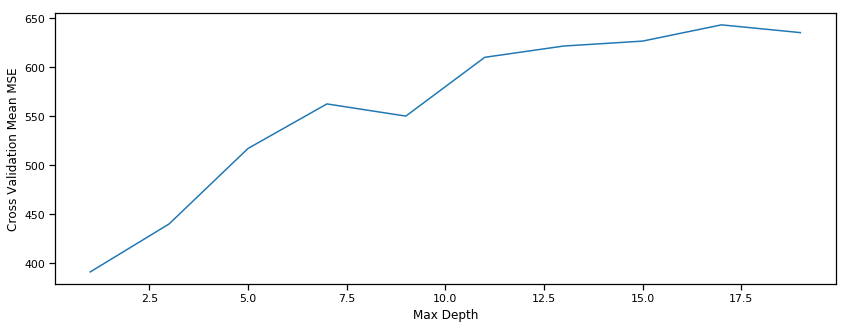

In [21]:
plt.figure(figsize=(14, 5))
plt.plot(hp_values, all_mu)
plt.ylabel('Cross Validation Mean MSE')
plt.xlabel('Max Depth')

Text(0.5, 0, 'Max Depth')

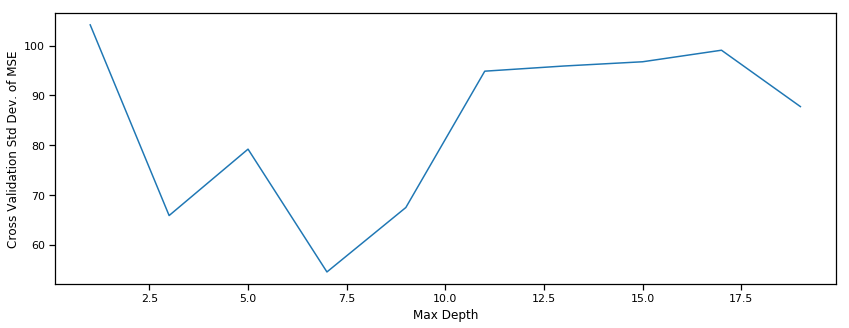

In [22]:
plt.figure(figsize=(14, 5))
plt.plot(hp_values, all_sigma)
plt.ylabel('Cross Validation Std Dev. of MSE')
plt.xlabel('Max Depth')

### Area Under the ROC curve 

In [ ]:
def plot_roc(regressor, label, color):

    regressor.fit(train_df[features], train_df[target])
    y_prob = regressor.predict(holdout_df[features])
    
    fpr, tpr, thresh = roc_curve(holdout_df[target], y_prob)
    plt.plot(fpr, tpr,
             label=label,
             color=color, linewidth=3)

    auc = roc_auc_score(holdout_df[target], y_prob[:,1])
    
    print('AUC: %0.3f (%s)' % (auc, label))

In [ ]:
f1 = plt.figure(figsize=(14,6))
gbm = GradientBoostingRegressor(
    random_state=random_state, 
    learning_rate = 0.01,
    min_samples_split=4,
    max_depth=6,
    n_estimators=100
)

plot_roc(gbm, 'GBM', 'lightblue')
